In [108]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

In [1]:
from util import *

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = sc.read_10x_h5(h5_path)
add_spatial_position(adata, csv_path)
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]

sc.pl.violin(adata, 
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [53]:
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 2179 × 13038
    obs: 'x', 'y', 'fig_x', 'fig_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'
    obsm: 'spatial'

In [30]:
result = convolve(get_3D_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

Transfer anndate to 3D matrix...


100%|████████████████████| 2179/2179 [00:08<00:00, 243.25it/s]100%


Convolve each 2D layer...


100%|████████████████████| 13038/13038 [00:52<00:00, 248.80it/s]100%


Update anndata...


  0%|                    | 0/2179 [00:00<?, ?it/s]  0%/Users/sunpeisen/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████| 2179/2179 [08:13<00:00,  4.42it/s]100%


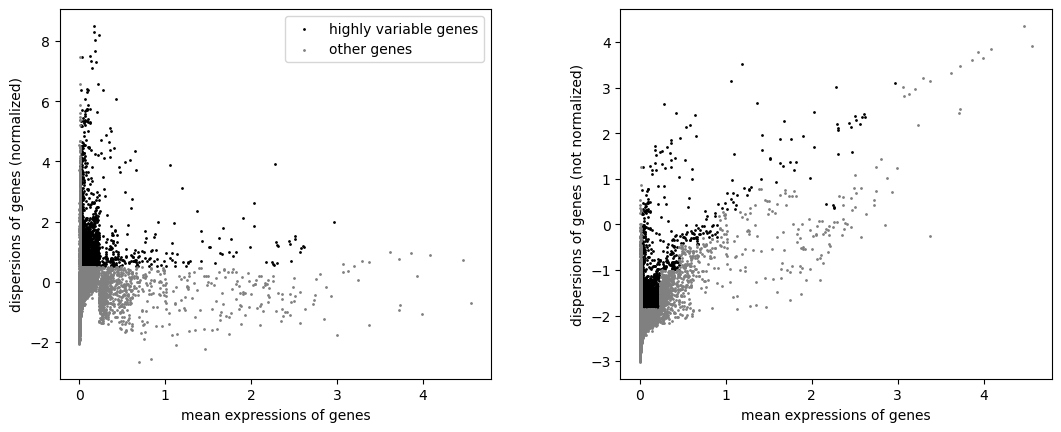

In [31]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [ ]:
# TODO: know why
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

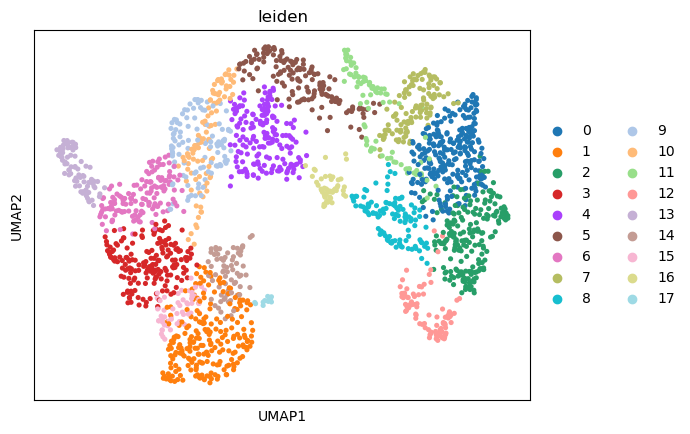

In [32]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [33]:
sq.pl.spatial_scatter(adata, color='leiden', shape=None, dpi=200, size=24)

In [16]:
tmp = adata[(adata.obs['leiden']=='3') |
            (adata.obs['leiden']=='0')]

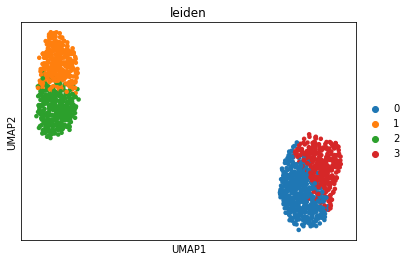

In [26]:
tmp.uns.pop('leiden_colors')
sc.tl.pca(tmp, svd_solver='arpack')
sc.pp.neighbors(tmp, n_neighbors=20, n_pcs=50)
sc.tl.umap(tmp)
sc.tl.leiden(tmp)
sc.pl.umap(tmp, color='leiden')

In [17]:
sq.pl.spatial_scatter(tmp, color='leiden', shape=None, dpi=200, size=24)

/Users/sunpeisen/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


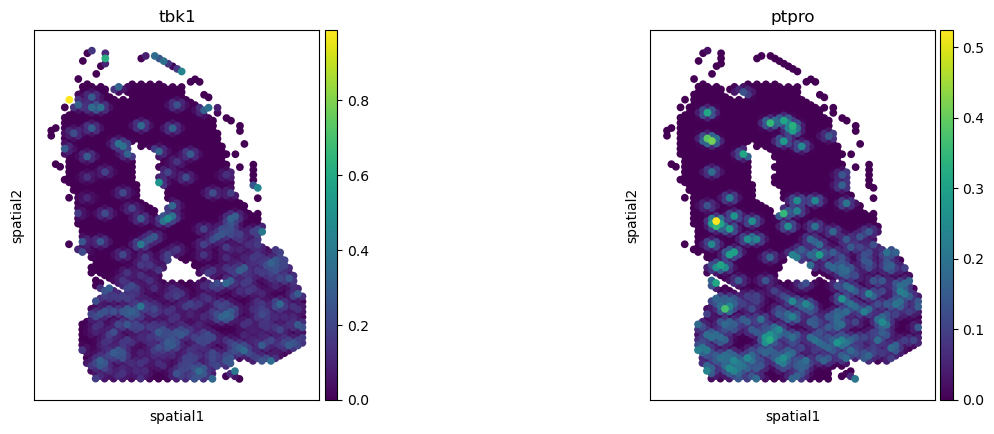

In [35]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=300,
              color=['tbk1','ptpro'])

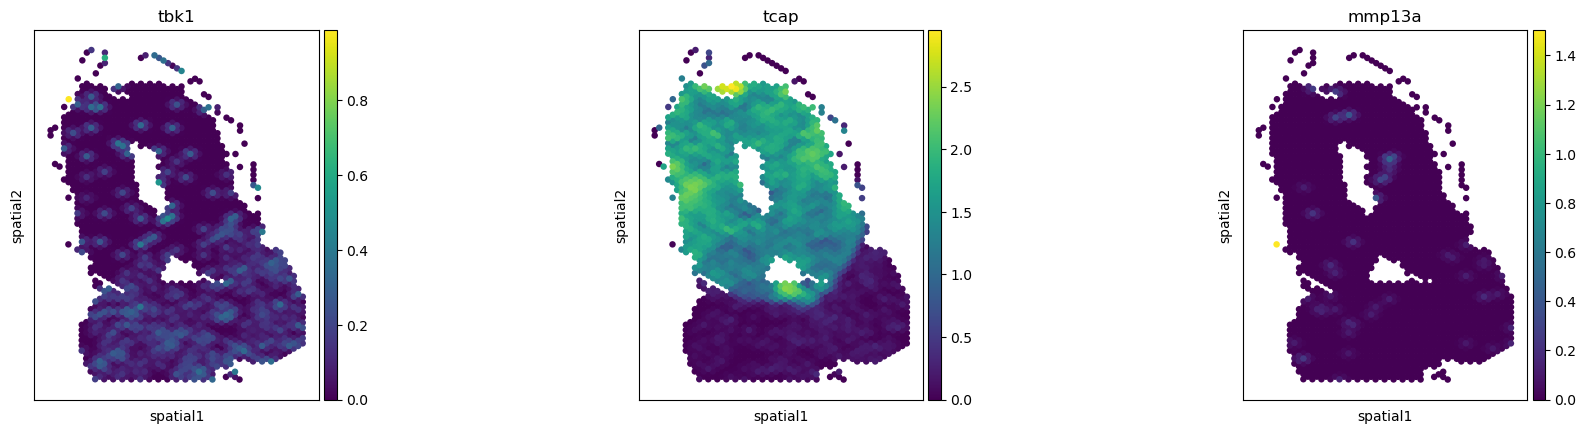

In [36]:

sc.pl.spatial(adata, 
              size=2,
              spot_size=250,
              color=['tbk1','tcap','mmp13a'],
              )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import mixture
from matplotlib.colors import LogNorm

mean_list = []

for gene_name in tqdm(adata.var_names):
    a = adata[:, adata.var_names == gene_name].X
    x = adata[a.todense() != 0].obs.fig_x.values
    y = adata[a.todense() != 0].obs.fig_y.values
    X_train = np.array([np.array(x), np.array(y)]).T
    clf = mixture.GaussianMixture(n_components=2,
                                  covariance_type="full",
                                  max_iter=50000)
    clf.fit(X_train)
    mean_list.append(clf.means_)

    # # display predicted scores by the model as a contour plot
    # x = np.linspace(0.0, 35000.0)
    # y = np.linspace(0.0, 35000.0)
    # X, Y = np.meshgrid(x, y)
    # XX = np.array([X.ravel(), Y.ravel()]).T
    # Z = -clf.score_samples(XX)
    # Z = Z.reshape(X.shape)

    # CS = plt.contour(
    #     X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 30)
    # )
    # CB = plt.colorbar(CS, shrink=0.8, extend="both")
    # plt.scatter(X_train[:, 0], X_train[:, 1], 0.8)

    # plt.title(gene_name)
    # plt.axis("tight")
    # plt.show()
    # print(clf.means_)
    # print(clf.weights_)
    # print(clf.covariances_)


In [54]:
adata.var_names[1]

'ptpro'

In [41]:
adata[:, adata.var_names == adata.var_names[1]].X

<2179x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1387 stored elements in Compressed Sparse Row format>

In [57]:
aaa = get_3D_matrix(adata[:, adata.var_names == 'tcap'])[:,:,0]

Transfer anndate to 3D matrix...


100%|████████████████████| 2179/2179 [00:04<00:00, 542.89it/s]100%


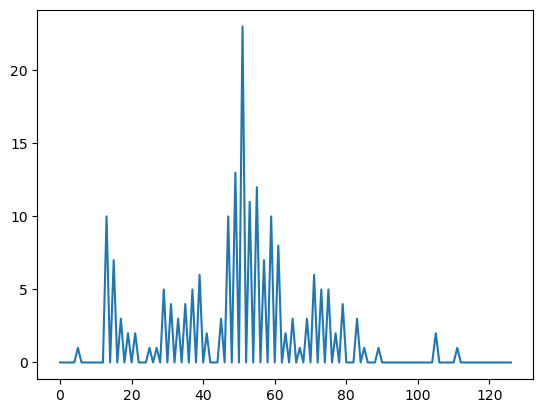

In [80]:
from scipy import signal

line = aaa[17,:]
new = signal.medfilt(line,3)
x = list(range(len(line)))
sns.lineplot(x=x,y=line)
plt.show()

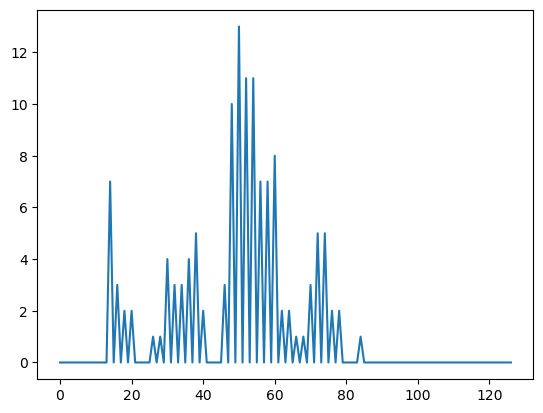

In [81]:
sns.lineplot(x=x,y=new)
plt.show()

In [46]:
from sklearn import mixture
clf = mixture.GaussianMixture(n_components=2,
                                covariance_type="full",
                                max_iter=50000)
clf.fit(aaa)

GaussianMixture(max_iter=50000, n_components=2)

In [51]:
aaa

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<AxesSubplot:xlabel='x', ylabel='y'>

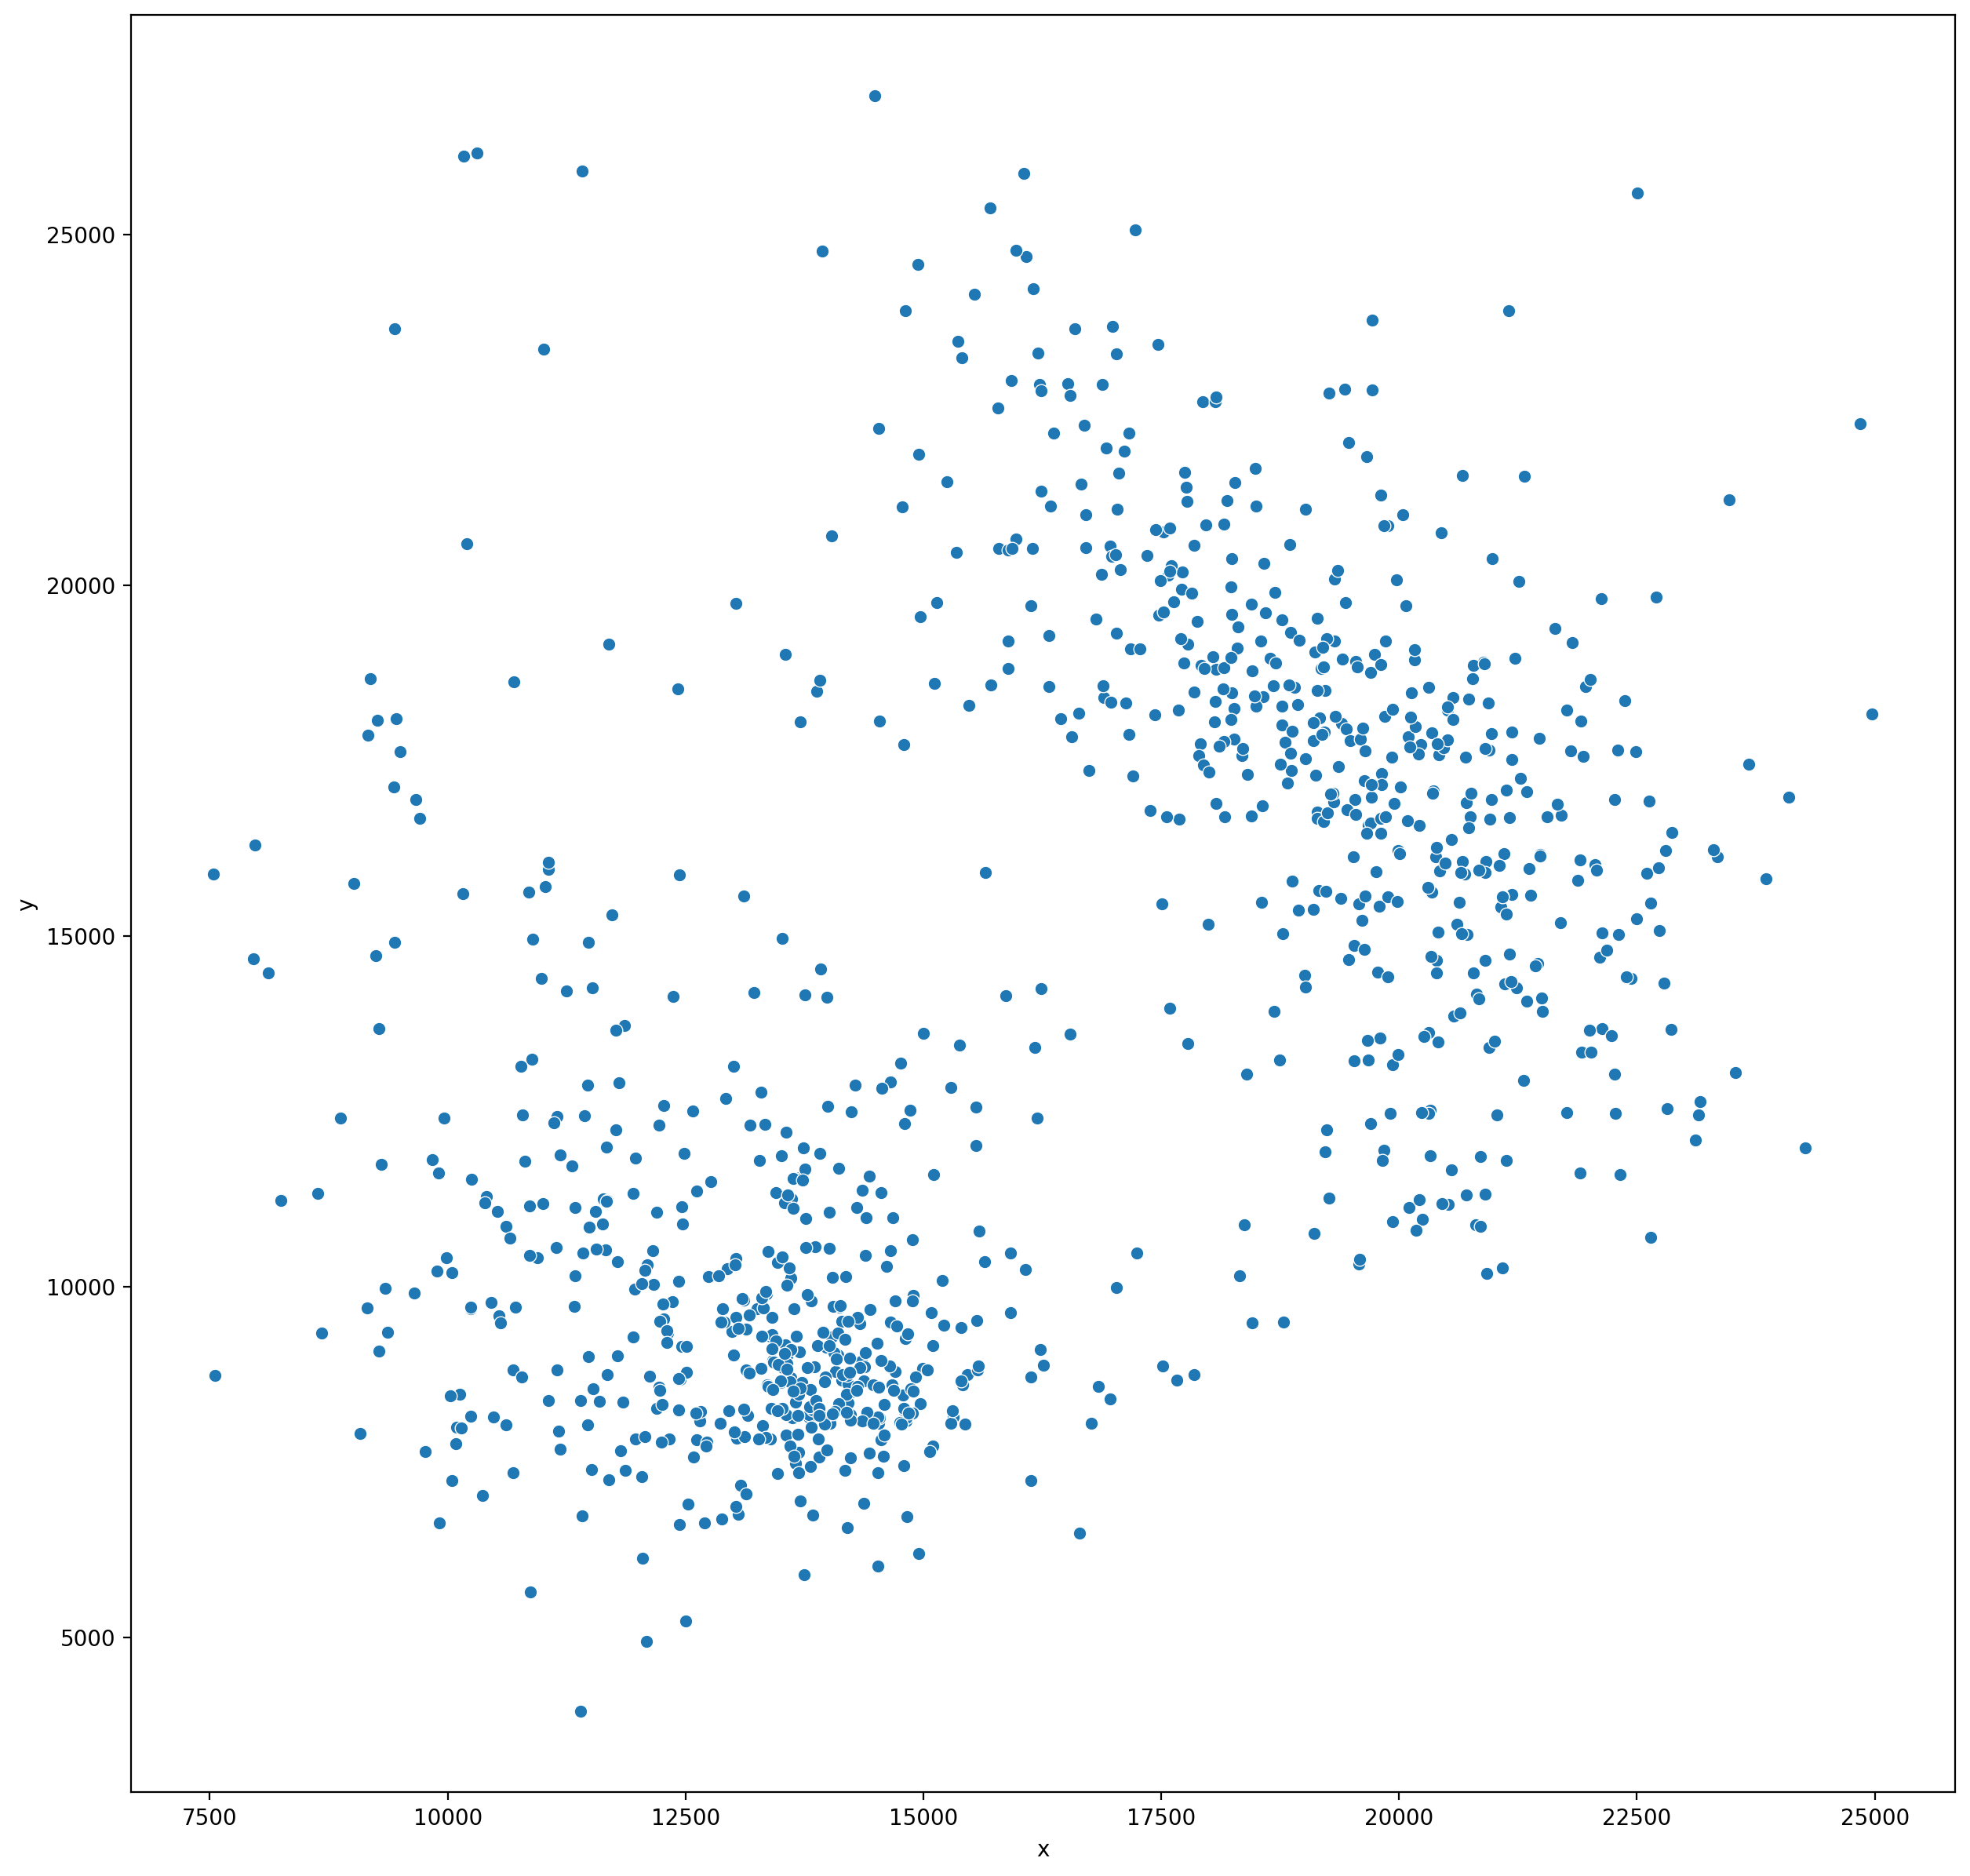

In [93]:
import seaborn as sns
total_list = []

for i in mean_list[:500]:
    for j in i:
        total_list.append(list(j))

df = pd.DataFrame(total_list,columns=['x','y'])


plt.figure(dpi=200, figsize=(10, 10))
sns.scatterplot(data = df,x='x',y='y')

In [94]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(total_list)
df['label'] = kmeans.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

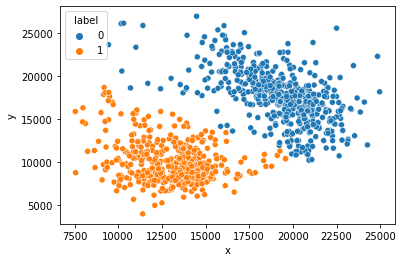

In [95]:
sns.scatterplot(data=df, x='x',y='y',hue='label')

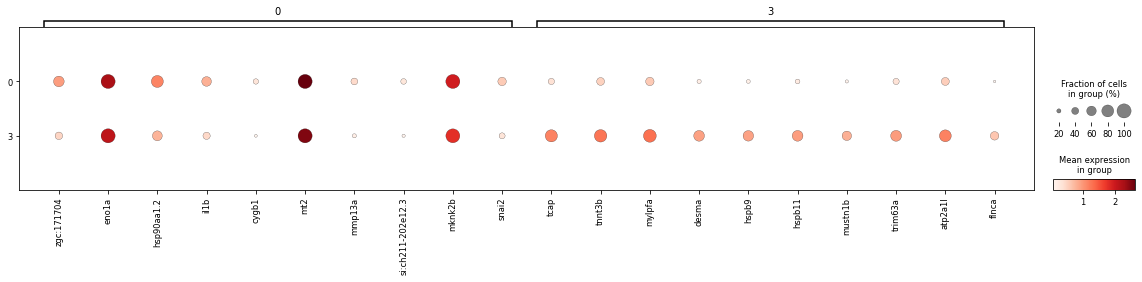

In [295]:
sc.tl.rank_genes_groups(tmp, groupby="leiden")
import matplotlib.pyplot as plt

sc.pl.rank_genes_groups_dotplot(tmp, 
                                groupby="leiden", 
                                figsize=(20,3)
                                )

f:\conda\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


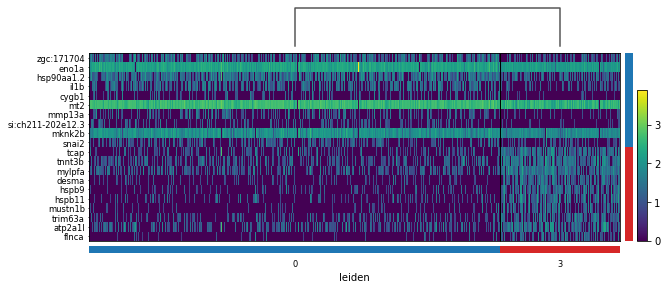

In [226]:
sc.pl.rank_genes_groups_heatmap(tmp, 
                                swap_axes=True,
                                groupby="leiden")

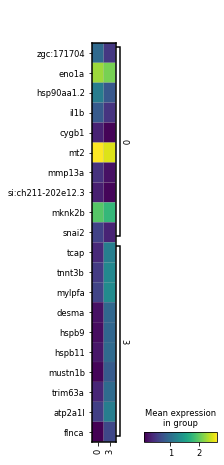

In [227]:
sc.pl.rank_genes_groups_matrixplot(tmp, groupby="leiden",swap_axes=True,)

f:\conda\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


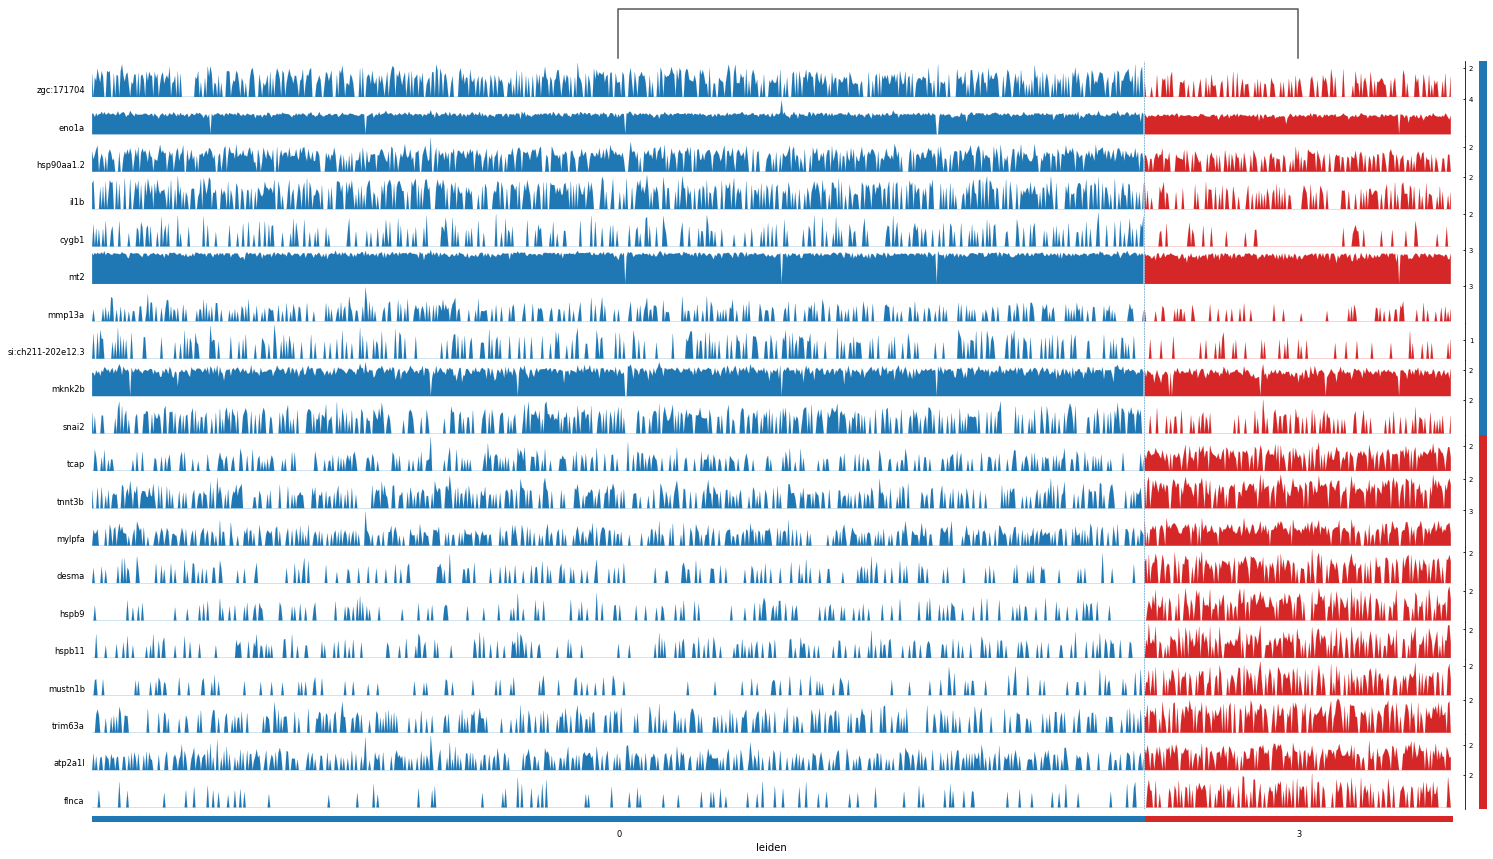

In [228]:
sc.pl.rank_genes_groups_tracksplot(tmp, figsize=(25,15))

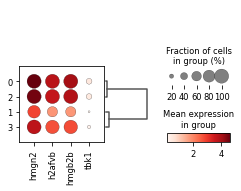

In [143]:
all_genes = ['hmgn2','h2afvb','hmgb2b','tbk1']
sc.pl.dotplot(tmp, 
              var_names=all_genes, 
              groupby='leiden', 
              dendrogram=True)

f:\conda\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


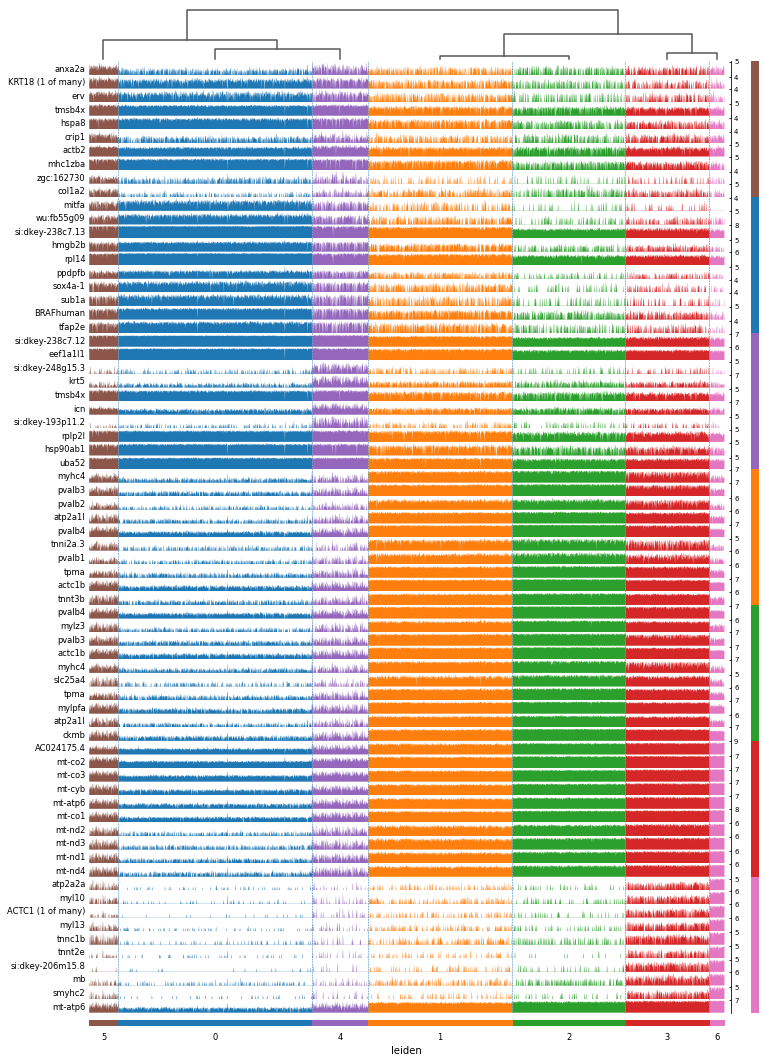

In [107]:
sc.tl.rank_genes_groups(adata, groupby="leiden")
sc.pl.rank_genes_groups_tracksplot(adata)

In [ ]:
get_mean_filter_kernel(3)

NameError: name 'get_mean_filter_kernel' is not defined